# CPM Predictor for Cognitive Score

In [86]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, t, ttest_1samp, pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.robust.robust_linear_model import RLM

import json
from joblib import dump

In [2]:
def normalise_correlate_fc(fc):
    fc_emp = fc / np.max(fc)
    fc_emp = np.corrcoef(fc_emp)
    return fc_emp

In [3]:
ADSP_DATA = '../data/ADSP_PHC_COGN_Dec2023_FILTERED_wfiles.csv'

df_mem = pd.read_csv(ADSP_DATA)
df_exf = pd.read_csv(ADSP_DATA)
df_lan = pd.read_csv(ADSP_DATA)
df_vsp = pd.read_csv(ADSP_DATA)

df_mem = df_mem.drop(columns=['RID', 'VISCODE2', 'PHC_Diagnosis', 'PHC_EXF', 'PHC_LAN', 'PHC_VSP'])
df_exf = df_exf.drop(columns=['RID', 'VISCODE2', 'PHC_Diagnosis', 'PHC_MEM', 'PHC_LAN', 'PHC_VSP'])
df_lan = df_lan.drop(columns=['RID', 'VISCODE2', 'PHC_Diagnosis', 'PHC_EXF', 'PHC_MEM', 'PHC_VSP'])
df_vsp = df_vsp.drop(columns=['RID', 'VISCODE2', 'PHC_Diagnosis', 'PHC_EXF', 'PHC_LAN', 'PHC_MEM'])
df_mem.shape

(1343, 3)

## Memory Model

In [4]:
df_mem.dropna(subset=['PHC_MEM'], inplace=True)
df_mem.shape

(1342, 3)

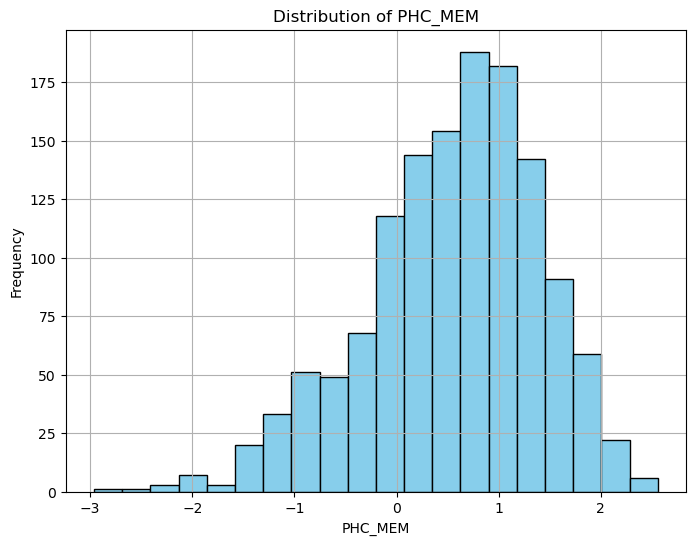

In [5]:
plt.figure(figsize=(8, 6))
plt.hist(df_mem['PHC_MEM'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of ' + 'PHC_MEM')
plt.xlabel('PHC_MEM')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
# Get features for training and testing

# Get the FC data as numpy arrays
dim_x = len(df_mem)
X = []

for i, file in enumerate(df_mem['FC_DATA'].values):
    arr = loadmat(file)['ROI_activity'][:100, :] # get the first 100 regions
    fc = normalise_correlate_fc(arr)
    X.append(fc)

In [7]:
X = np.array(X)

In [15]:
Y = df_mem['PHC_MEM']
Y.shape

(1342,)

In [8]:
X.shape
X_transposed = np.transpose(X, (1, 2, 0))
X_transposed.shape

(100, 100, 1342)

In [10]:
# threshold for feature selection
threshold = 0.01

In [11]:
num_subj = X_transposed.shape[2]
num_nodes = X_transposed.shape[0]

behav_pred_pos = np.zeros((num_subj, 1))
behav_pred_neg = np.zeros((num_subj, 1))
behav_pred = np.zeros((num_subj, 1))

In [94]:
# Leave-one-subject-out cross validation

for leftout in range(0, num_subj):
    print('Leaving out subject ', leftout)
    
    # leave out subject from matrices and behaviour
    train_mats = np.delete(X_transposed, leftout, axis=2)  # Remove the left-out subject's matrix
    train_vcts = np.reshape(train_mats, (-1, train_mats.shape[2]))  # Reshape into vectors
    
    train_behav = np.delete(Y, leftout)  # Remove the left-out subject's behavior

    r_mat, p_mat = spearmanr(train_vcts.T, train_behav)
    
    r_mat = r_mat[:num_nodes, :num_nodes]
    p_mat = p_mat[:num_nodes, :num_nodes]
    
    # setting thresholds and defining masks
    pos_mask = np.zeros((num_nodes, num_nodes))
    neg_mask = np.zeros((num_nodes, num_nodes))

    # Find positive edges based on threshold
    pos_edge = np.where((r_mat > 0) & (p_mat < threshold))

    # Find negative edges based on threshold
    neg_edge = np.where((r_mat < 0) & (p_mat < threshold))

    pos_mask[pos_edge] = 1
    neg_mask[neg_edge] = 1
    
    # Form single-subject summary values - get sum of all edges and divide by 2 to account for
    # symmetric matrices
    train_sumpos = np.zeros(num_subj - 1)
    train_sumneg = np.zeros(num_subj - 1)
    
    for subj in range(num_subj-1):
        train_sumpos[subj] = np.sum(np.sum(train_mats[:, :, subj] * pos_mask)) / 2
        train_sumneg[subj] = np.sum(np.sum(train_mats[:, :, subj] * neg_mask)) / 2
        
    # Build linear regression model on training data
    # combining positive + negative features, without intercept
    
    X_train = np.column_stack((train_sumpos, train_sumneg))
    regressor = LinearRegression(fit_intercept=False)  
    regressor.fit(X_train, train_behav)
    
    # Predict on new data 
    
    test_mat = X_transposed[:, :, leftout]
    test_sumpos = np.sum(np.sum(test_mat * pos_mask)) / 2
    test_sumneg = np.sum(np.sum(test_mat * neg_mask)) / 2
    behav_pred[leftout] = regressor.predict([[test_sumpos, test_sumneg]])
    

Leaving out subject  0
Leaving out subject  1
Leaving out subject  2
Leaving out subject  3
Leaving out subject  4
Leaving out subject  5
Leaving out subject  6
Leaving out subject  7
Leaving out subject  8
Leaving out subject  9
Leaving out subject  10
Leaving out subject  11
Leaving out subject  12
Leaving out subject  13
Leaving out subject  14
Leaving out subject  15
Leaving out subject  16
Leaving out subject  17
Leaving out subject  18
Leaving out subject  19
Leaving out subject  20
Leaving out subject  21
Leaving out subject  22
Leaving out subject  23
Leaving out subject  24
Leaving out subject  25
Leaving out subject  26
Leaving out subject  27
Leaving out subject  28
Leaving out subject  29
Leaving out subject  30
Leaving out subject  31
Leaving out subject  32
Leaving out subject  33
Leaving out subject  34
Leaving out subject  35
Leaving out subject  36
Leaving out subject  37
Leaving out subject  38
Leaving out subject  39
Leaving out subject  40
Leaving out subject  41
Le

KeyboardInterrupt: 

In [89]:
pred = behav_pred[:100]
pred.shape

(100, 1)

In [90]:
actual = Y[:100]
actual.shape

(100,)

In [91]:
# Calculate MSE
mse = round(mean_squared_error(actual, pred),2)

print(f'mse: {mse}')

mse: 0.79


In [92]:
r2_score = round(r2_score(actual, pred),2)

print(f'r2: {r2_score}')

r2: -0.26
